# Nullspace Movement

Author: Michael Greer

This notebook introduces the concept of nullspace movement with redundant manipulators. Nullspace movement is often paired with differential kinematics to perform local optimization while still meeting task space movement constraints.
$$\newcommand{\R}{\mathbb{R}}$$

### Null Space of a Matrix

The null space $N$ of a matrix $L:V\Rightarrow W$ is defined as follows:

$$ N=Null(L)=\{\forall v\in V|Lv=0\}$$

This might be confusing for those unfamiliar with set theory, so let's break it down more simply. Given a matrix that maps a vector space $V$ to a vector space $W$, the null space of that matrix consists of all vectors $v$ in $V$ such that when $v$ is mapped into $W$ using $L$, the resultant vector is the zero vector. 

The size of a null space of a matrix is given by:

$$dim(N)=rank(L)-dim(W)$$

For a full-rank $L$ and $dim(V)>dim(W)$ this becomes:

$$dim(N)=dim(V)-dim(W)$$

### Physical Meaning

In the context of redundant manipulators, the null space has a very clear meaning. Consider a jacobian for a redundant manipulator. From a previous notebook, we know:

$$\dot{x}=J\dot{\theta}$$

For a redundant manipulator, the dimension of the joint space is larger than the dimension of the work space by definition. Since the jacobian maps joint movement to workspace movement, we can consider joint velocities that exist in the null space of the jacobian:

$$\dot{x}=J\dot{\theta}=0,\forall \dot{\theta}\in Null(J)$$

By this definition, joint velocities in the null space of the jacobian generate zero velocity in the workspace. To visualize this, hold an object in your hand, then move your elbow while trying to keep the object still. Your arm is moving in the null space of it's jacobian. 

This is a very powerful result, as it allows us to perform secondary optimizations while maintaining our original inverse kinematics goal.

### Null Space Projection

Now that we know that these joint velocity vectors exist, how do we find them? The answer is projection. For a subspace $L$ of $\R^{n}$, we can project vectors in $\R ^{n}$ but *not* $L$ onto $L$ using the projection matrix:
$$P = L(L^{T}L)^{-1}L^{T}$$
Using $P$, $w=Pv$ gives the closest possible vector $w\in L$ to $v$. This process is called orthogonal projection.

Tying this back to robotic movement, we can generate a joint velocity vector that improves an objective function. Then, we project that desired joint movement onto the null space of the jacobian so that the movement does not impede inverse kinematics. This approach has been used to optimize robotic movement for lots of different objectives, such as collision avoidance, joint limit avoidance, and manipulability improvement.

The concepts just discussed are implemented below. The plot_robot, f_kine, and jacobian functions are copies from earlier documents. The i_kine_null function is similar to previous inverse kinematics functions, but implements joint control according to the comment above the function header. Remember that, as with any algorithm using a jacobian, the null space membership only holds locally. It's important to make small movements in the null space paired with online inverse kinematics to prevent the null space movement vector from affecting workspace movement when the linear relationship breaks down.

In [2]:
import numpy as np
from numpy import cos, sin, pi

from scipy.linalg import null_space

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sympy as sp

In [3]:
def plot_robot(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    xs = [0]
    ys = [0]
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        xs.append(xs[-1] + l * cos(total_q))
        ys.append(ys[-1] + l * sin(total_q))
        
    plt.figure(figsize=(8,8))
    plt.plot(xs, ys)
    plt.ylim(-1 * total_len, total_len)
    plt.xlim(-1 * total_len, total_len)
    plt.title('Robot Manipulator Pose')
    
    return

In [4]:
def f_kine(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    x = 0
    y = 0
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        x += l * cos(total_q)
        y += l * sin(total_q)
        
    return np.array([[x],[y]])

In [5]:
def jacobian(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
            
    # Form symbolic q matrix
    
    qs = []
    
    for i in range(0,len(joints)):
        
        qs.append(sp.Symbol('q{}'.format(i)))
        
        
    jac = np.zeros((2, len(links)))
    
    x = 0
    y = 0
    
    # Form forward kinematics
    for i in range(len(links)):
                   
        total_q = 0
        
        for j in range(i + 1):
            
            total_q += qs[j]
            
        x += links[i] * sp.cos(total_q)
        y += links[i] * sp.sin(total_q)
        
    
    # Differentiate to find jacobian      
    for i in range(len(links)):
        
        Jx = sp.diff(x, qs[i])
        Jy = sp.diff(y, qs[i])
        
        for k in range(len(links)):
            
            Jx = Jx.subs(qs[k], joints[k])
            Jy = Jy.subs(qs[k], joints[k])
                
        jac[0,i] = Jx.evalf()
        jac[1,i] = Jy.evalf()
            
    return jac

In [6]:
# Note: this ONLY works for targets within the workspace. For points outside the workspace this function will not exit
# q_des is the desired joint values that the i_kine should optimize for
# q_des_mask tells the function which joints we care about. Used for only specifying motion for select joints.
def i_kine_null(links, joints, target, q_des, q_des_mask, error_trace=False):
    
    current_q = joints
    
    # This term limits the maximum delta x per move
    max_move = 2
    
    e_trace = []
    
    while(1):
        
        # Get the current end effector position
        current_x = f_kine(links, current_q)
        
        # Get the vector to the target
        delta_x = target - current_x
        
        # Find the magnitude of the movement required
        delta_x_norm = np.linalg.norm(delta_x)
        
        e_trace.append(delta_x_norm)
        
        # Limit the maximum magnitude of delta_x
        if (delta_x_norm > max_move):
            
            delta_x /= (delta_x_norm / max_move)
            
        q_err = np.multiply(q_des - current_q, q_des_mask)    
            
        
        jac = jacobian(links, current_q)
        
        # Jacobian pseudoinversion
        jac_pinv = np.linalg.pinv(jac)
        
        # Null space of jacobian, and projection matrix
        # We just use the scipy function to find it, much faster than solving it ourselves
        jac_null = null_space(jac)
        
        null_project = jac_null @ np.linalg.inv(jac_null.T @ jac_null) @ jac_null.T
        
        # Find the required movements in the joint space
        alpha = 0.8
        beta = 0.8
        delta_q = alpha * jac_pinv @ delta_x + beta * (null_project @ q_err)
        
        # Add the change to find the updated joint angles
        current_q += delta_q
        
        # Stop if the end effector is sufficently close to target
        if (delta_x_norm < 0.001 and np.linalg.norm(delta_q) < 0.001):
            
            break
        
    return (current_q, e_trace) if error_trace else current_q

### Analysis

This is a very narrow implementation that is only able to target specific joint values instead of general joint movement. This is a bit limiting, but this implementation helps understand the concept.

First, let's consider the case where each joint has the center of it's range of motion at $\theta=0$. We can solve the inverse kinematics for a workspace target while also moving the joint values to stay as close to the center of their range as possible. An example of this is shown below.

If you're interested in modifying the code to understand it better, try modifying the following code so that the second joint targets a specific value.

Text(0.5, 1.0, 'Error Trace')

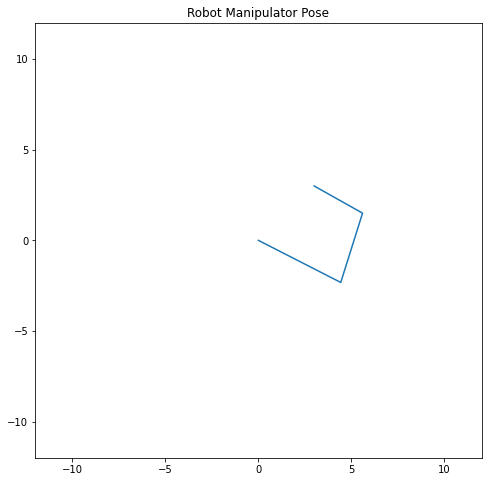

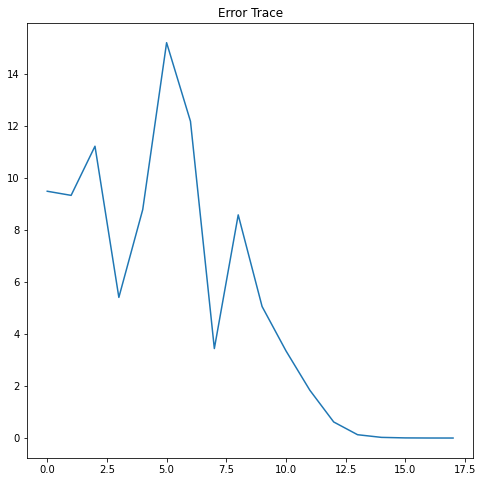

In [13]:
links = [5.0, 4.0, 3.0]
joints = np.array([[0.0],[0.0],[0.0]])
target = np.array([[3.0],[3.0]])

# Desired joint values
q_des = np.array([[0.0],[0.0],[0.0]])

# Joint mask to tell the algorithm which joints we actually care about
q_des_mask = np.array([[1],[1],[1]])

joints, e_trace = i_kine_null(links, joints, target, q_des, q_des_mask, error_trace=True)

plot_robot(links, joints)

plt.figure(figsize=(8,8))
plt.plot(e_trace)
plt.title('Error Trace')

It might not be immediately obvious, but this solution does in fact minimize the total joint distance from the centers of motion of each joint. This serves as a very basic form of joint limit avoidance, but more sophistocated algorithms scale the desired joint movement up as the joint approaches a limit.

You might be wondering what the null space looks like. Below, we traverse the null space of a certain workspace target by iteratively requesting different joint targets for the third joint. This is a 3-DOF robot in 2-D space, so for a full-rank jacobian we should see that the null space is a 1-D manifold of the 3-D joint space. We plot the manifold below. 

Text(0, 0.5, 'q3')

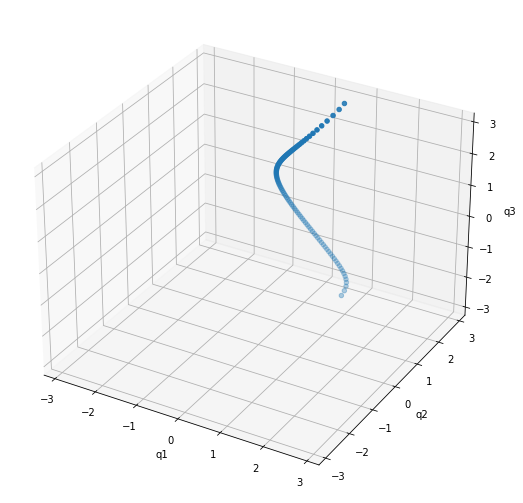

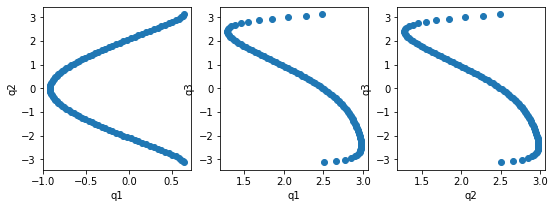

In [14]:
# We can use this to plot the self motion manifold in 3D space.

q1_null = []
q2_null = []
q3_null = []

# We only care about the third joint value
q_des_mask = np.array([[0],[0],[1]])

# Run inverse kinematics for all possible target values for the third joint
for i in np.linspace(-pi, pi, 100):
        
    q_des = np.array([[0.0],[0.0],[i]])
    
    # Run inverse kinematics
    joints, e_trace = i_kine_null(links, joints, target, q_des, q_des_mask, error_trace=True)
    
    joints_list = np.squeeze(joints)
        
    q1_null.append(joints_list[0])
    q2_null.append(joints_list[1])
    q3_null.append(joints_list[2])
                
# Move all joint values into the (-pi,pi) range
for i in range(len(q1_null)):
    
    q1_null[i] = (q1_null[i] + pi) % (2 * pi) - pi
    q2_null[i] = (q2_null[i] + pi) % (2 * pi) - pi
    q3_null[i] = (q3_null[i] + pi) % (2 * pi) - pi

# Plot the values
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(-pi,pi)
ax.set_ylim3d(-pi,pi)
ax.set_zlim3d(-pi,pi)

ax.set_xlabel('q1')
ax.set_ylabel('q2')
ax.set_zlabel('q3')

ax.scatter(q1_null, q2_null, q3_null)

fig = plt.figure(figsize=(9,3))

ax1 = fig.add_subplot(131)
ax1.scatter(q1_null, q3_null)
ax1.set_xlabel('q1')
ax1.set_ylabel('q2')

ax2 = fig.add_subplot(132)
ax2.scatter(q2_null, q3_null)
ax2.set_xlabel('q1')
ax2.set_ylabel('q3')

ax3 = fig.add_subplot(133)
ax3.scatter(q2_null, q3_null)
ax3.set_xlabel('q2')
ax3.set_ylabel('q3')

This plots a continuum of confiturations that are able to satisfy the desired target. Note that targets can have multiple manfolds that merge and diverge at different configurations. This is the null space for one target, and the manifold can look very different for different targets.